In [1]:
import scipy.spatial as spatial
import numpy as np
import matplotlib.pyplot as plt
from more_itertools import powerset
import mpl_toolkits.mplot3d as a3
from wireframes import wireframe_sphere
from rich import print
from itertools import combinations

In [2]:
X = np.asarray([
    [0,0],
    [0.5, 0],
    [0.25, 0.5 * np.sqrt(3)/2 ],
    [ 0.75/3, (0.5 * np.sqrt(3)/2)/3 ],
])
#X = np.random.rand(4,3)
X = np.random.rand(50, 2)
dimension = X.shape[1]

In [3]:
def cayley_menger_matrix(X):
    d = X.shape[1]
    dm = np.power(spatial.distance_matrix(X,X), 2)
    m = np.zeros(np.asarray(dm.shape) + 1)
    m[:,0] = 1
    m[0,:] = 1
    m[0,0] = 0
    m[1:,1:] = dm
    return m

In [4]:
def merge_dicts(d1 : dict, d2 : dict, arbiter):
    #print("d1")
    k1 = set(d1.keys())
    #print(d1)
    #print("d2")
    #print(d2)
    k2 = set(d2.keys())
    meet = k1.intersection(k2)
    join = k1.union(k2)
    h = { k : d1[k] if k not in d2 else d2[k] for k in join - meet}
    for k in meet:
        h[k] = arbiter(d1[k], d2[k])
    
    #print("h")
    #print(h)
        
    return h

The Cartesian coordinates of any point are a weighted average
of the Cartesian coordinates of the triangle's vertices,
with the weights being the point's barycentric coordinates summing to unity. So e.g. for a triangle:
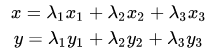

-- for plotting tetrahedrons:
         "you draw a point by drawing a point"
         "you draw a line by connecting its points"
         "you draw a triangle by connecting its lines"
         "you draw a tetrahedron by connecting its triangles"
         "you draw a 4-simplex by connecting its tetrahedrons"
        .... etc.

In [5]:
def cech(kdtree, simplex, parent_value = None, ax = None):
    X = kdtree.data
    if len(simplex) == 0:
        return dict()
    elif len(simplex) == 1:
        return { simplex : 0.0 }
    
    # https://westy31.home.xs4all.nl/Circumsphere/ncircumsphere.htm
    content_inv  = np.linalg.inv(cayley_menger_matrix( X[simplex,:] ))
    circumradius = np.sqrt(content_inv[0,0]/-2)
    circumcentre = content_inv[1:,0].dot( X[simplex,:] )
    
    # a face is Gabriel if there are no other vertices within the d-ball
    _,nn = kdtree.query(circumcentre, k = len(simplex))
    assert len(nn) >= len(simplex)
    
    if set(nn) != set(simplex): # not Gabriel
        F = { tuple(sorted(simplex)) : parent_value }
    else:
        F = { tuple(sorted(simplex)) : circumradius }
    
    #---- Plotting
    if ax is not None:
        plot_color = { 2 : "black", 3 : "red", 4 : "blue" }
        plot_color = plot_color[len(simplex)]
        ax.scatter(*tuple(circumcentre), color = plot_color, marker = "o", facecolors='none', s = 100, alpha = 1)
        for y in X[simplex, :]:
            connecting_lines = (
                [circumcentre[0],y[0]],
                [circumcentre[1],y[1]],
                [circumcentre[2],y[2]]
            ) if dimension == 3 else (
                [circumcentre[0],y[0]],
                [circumcentre[1],y[1]],
            )
            ax.plot(
                *connecting_lines,
                "--",
                color = plot_color,
                alpha = 0.4
            )
        if set(nn) != set(simplex):
            ax.scatter(
                *tuple(circumcentre),
                color = plot_color,
                marker = "x",
                s = 100,
                alpha = 1
            )
    
    #----- Recurse faces
    sub = combinations(simplex, len(simplex)-1)
    for f in sub:
        F = merge_dicts(
            F,
            cech(
                kdtree = kdtree,
                simplex = f,
                parent_value = circumradius,
                ax = ax
            ),
            min
        )
    return F

<IPython.core.display.Javascript object>


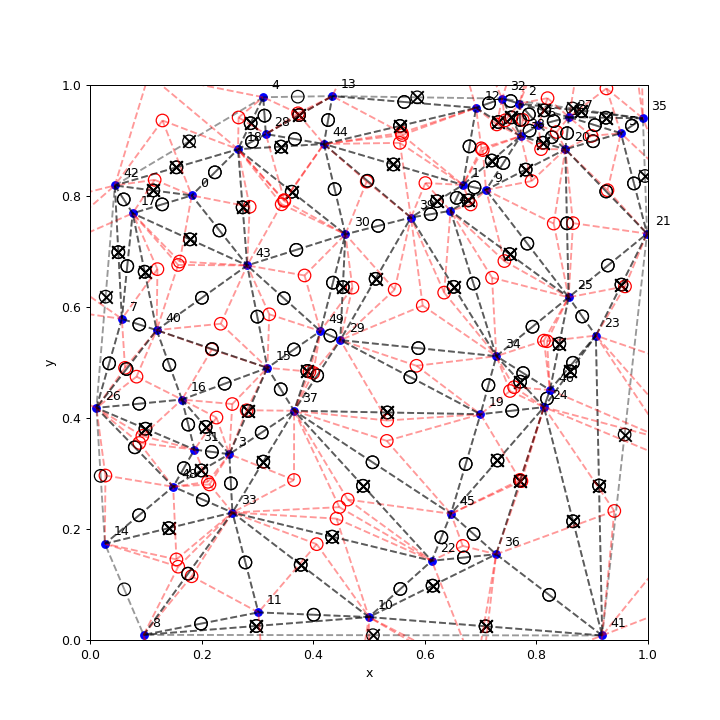

In [6]:
%matplotlib notebook

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection = "3d") if dimension == 3 else fig.add_subplot()

tri = list() if dimension == 3 else None
kdtree = spatial.KDTree(X) # X is in R^d
cech_complex = dict()

for t in spatial.Delaunay(X).simplices:
    if dimension == 3:
        for f in combinations(t, 3):
            tri.append(f)
    #    
    cech_complex = merge_dicts(
        cech_complex,
        cech(
            kdtree = kdtree,
            simplex = t,
            ax = ax
        ),
        min
    )

cech_complex = list(cech_complex.items())
if dimension == 3:
    plt_tri = a3.art3d.Poly3DCollection(X[tri, :])
    plt_tri.set_alpha(0.1)
    plt_tri.set_color('grey')
    ax.add_collection3d(plt_tri)

for i,x in enumerate(X):
    ax.scatter(*tuple(x), color = "blue")
    ax.text(*tuple(x+0.015), s=str(i))
    
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1) if dimension == 3 else None
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z") if dimension == 3 else None
plt.show()

In [7]:
print(len(cech_complex))
for sigma in sorted(cech_complex, key = lambda t: t[1]) :
    print("{:.5f}".format(sigma[1])+"\t\t"+str(sigma[0]))

275

0.00000         (20,)

0.00000         (29,)

0.00000         (47,)

0.00000         (13,)

0.00000         (22,)

0.00000         (31,)

0.00000         (40,)

0.00000         (49,)

0.00000         (15,)

0.00000         (24,)

0.00000         (33,)

0.00000         (42,)

0.00000         (8,)

0.00000         (17,)

0.00000         (26,)

0.00000         (35,)

0.00000         (44,)

0.00000         (1,)

0.00000         (10,)

0.00000         (19,)

0.00000         (28,)

0.00000         (37,)

0.00000         (3,)

0.00000         (12,)

0.00000         (21,)

0.00000         (30,)

0.00000         (5,)

0.00000         (14,)

0.00000         (23,)

0.00000         (7,)

0.00000         (16,)

0.00000         (25,)

0.00000         (0,)

0.00000         (9,)

0.00000         (18,)

0.00000         (11,)

0.00000         (4,)

0.00000         (46,)

0.00000         (39,)

0.00000         (48,)

0.00000         (32,)

0.00000         (41,)

0.00000         (34,)

0.00000         (43,)

0.00000         (27,)

0.00000         (36,)

0.00000         (45,)

0.00000         (6,)

0.00000         (2,)

0.00000         (38,)

0.01616         (2, 32)

0.01637         (24, 46)

0.01884         (6, 38)

0.01951         (29, 49)

0.02119         (1, 9)

0.02384         (5, 35)

0.02483         (12, 32)

0.02589         (2, 6)

0.02593         (1, 47)

0.02828         (6, 27)

0.02841         (18, 28)

0.02918         (20, 27)

0.02944         (2, 38)

0.02976         (17, 42)

0.02983         (2, 6, 38)

0.03148         (3, 31)

0.03245         (6, 20)

0.03278         (7, 40)

0.03330         (4, 28)

0.03482         (6, 20, 27)

0.03594         (39, 47)

0.03797         (1, 9, 47)

0.03797         (9, 47)

0.03856         (31, 48)

0.03978         (32, 38)

0.03978         (2, 32, 38)

0.04229         (23, 25)

0.04350         (6, 20, 38)

0.04350         (20, 38)

0.04385         (13, 44)

0.04553         (15, 37)

0.04574         (22, 45)

0.04649         (16, 31)

0.04769         (12, 38)

0.04769         (12, 32, 38)

0.04874         (5, 27)

0.05137         (2, 27)

0.05137         (2, 6, 27)

0.05186         (5, 20)

0.05269         (3, 33)

0.05277         (28, 44)

0.05281         (5, 20, 27)

0.05424         (19, 34)

0.05451         (36, 45)

0.05530         (0, 17)

0.05694         (34, 46)

0.05724         (19, 24)

0.05728         (4, 18, 28)

0.05728         (4, 18)

0.05755         (9, 38)

0.05796         (33, 48)

0.05798         (15, 49)

0.05801         (22, 36)

0.05884         (0, 18)

0.06064         (30, 39)

0.06170         (22, 36, 45)

0.06193         (4, 13)

0.06288         (3, 31, 48)

0.06288         (3, 48)

0.06402         (23, 46)

0.06444         (24, 34)

0.06444         (24, 34, 46)

0.06519         (3, 33, 48)

0.06658         (16, 40)

0.06736         (1, 39, 47)

0.06736         (1, 39)

0.06746         (19, 24, 34)

0.06871         (13, 28)

0.06871         (13, 28, 44)

0.06881         (4, 13, 28)

0.06990         (3, 16, 31)

0.06990         (3, 16)

0.07004         (3, 37)

0.07046         (1, 12)

0.07211         (0, 42)

0.07211         (0, 17, 42)

0.07222         (1, 9, 38)

0.07222         (1, 38)

0.07369         (1, 12, 38)

0.07573         (15, 37, 49)

0.07573         (37, 49)

0.07579         (10, 22)

0.07598         (29, 37)

0.07645         (29, 37, 49)

0.07702         (16, 26)

0.07995         (14, 48)

0.08036         (0, 43)

0.08172         (15, 16)

0.08327         (9, 20)

0.08327         (9, 20, 38)

0.08344         (7, 26)

0.08366         (30, 44)

0.08374         (25, 34)

0.08477         (5, 27, 35)

0.08477         (27, 35)

0.08508         (3, 15)

0.08508         (3, 15, 37)

0.08817         (23, 25, 46)

0.08817         (25, 46)

0.08842         (43, 49)

0.08847         (26, 40)

0.08853         (7, 26, 40)

0.08917         (8, 14)

0.08977         (25, 34, 46)

0.09013         (30, 49)

0.09061         (3, 15, 16)

0.09073         (21, 25)

0.09131         (16, 26, 40)

0.09237         (30, 43)

0.09304         (11, 33)

0.09359         (5, 21)

0.09365         (19, 45)

0.09411         (15, 43)

0.09571         (7, 17)

0.09662         (15, 43, 49)

0.09664         (16, 26, 31)

0.09664         (26, 31)

0.09708         (29, 30)

0.09708         (29, 30, 49)

0.09894         (26, 48)

0.09913         (10, 11)

0.09959         (26, 31, 48)

0.09996         (40, 43)

0.10239         (39, 44)

0.10241         (30, 39, 44)

0.10297         (21, 23)

0.10297         (21, 23, 25)

0.10433         (30, 43, 49)

0.10483         (8, 11)

0.10489         (15, 40)

0.10489         (15, 16, 40)

0.10560         (20, 21)

0.10565         (5, 20, 21)

0.10590         (18, 43)

0.10590         (0, 18, 43)

0.11006         (17, 40)

0.11006         (7, 17, 40)

0.11050         (5, 21, 35)

0.11050         (21, 35)

0.11540         (15, 40, 43)

0.11999         (36, 41)

0.12116         (0, 17, 43)

0.12116         (17, 43)

0.12187         (9, 25)

0.12282         (14, 26)

0.12312         (14, 26, 48)

0.12371         (18, 44)

0.12371         (18, 28, 44)

0.12377         (17, 40, 43)

0.12487         (18, 30)

0.12487         (18, 30, 44)

0.12496         (33, 37)

0.12496         (3, 33, 37)

0.12640         (18, 30, 43)

0.12920         (12, 13)

0.13126         (14, 33)

0.13126         (14, 33, 48)

0.13240         (25, 47)

0.13240         (9, 25, 47)

0.13331         (29, 30, 39)

0.13331         (29, 39)

0.13354         (20, 25)

0.13398         (20, 21, 25)

0.13564         (9, 20, 25)

0.13606         (8, 33)

0.13611         (1, 39, 44)

0.13611         (1, 44)

0.13629         (8, 11, 33)

0.13735         (34, 47)

0.13776         (8, 14, 33)

0.13809         (24, 45)

0.13809         (19, 24, 45)

0.13943         (24, 36)

0.13943         (24, 36, 45)

0.14059         (29, 34)

0.14077         (12, 44)

0.14077         (12, 13, 44)

0.14120         (1, 12, 44)

0.14173         (25, 34, 47)

0.14231         (19, 29)

0.14419         (19, 29, 34)

0.14502         (0, 18, 42)

0.14502         (18, 42)

0.14793         (34, 39, 47)

0.14793         (34, 39)

0.16032         (29, 34, 39)

0.16144         (10, 11, 33)

0.16144         (10, 33)

0.16765         (19, 29, 37)

0.16765         (19, 37)

0.16847         (37, 45)

0.17471         (19, 37, 45)

0.18678         (22, 37)

0.18678         (22, 37, 45)

0.18687         (10, 22, 33)

0.18687         (22, 33)

0.19183         (22, 33, 37)

0.19444         (7, 17, 42)

0.19444         (7, 42)

0.20919         (4, 18, 42)

0.20919         (4, 42)

0.21571         (10, 36)

0.21571         (10, 22, 36)

0.22463         (23, 24)

0.22463         (23, 24, 46)

0.22569         (24, 41)

0.22569         (24, 36, 41)

0.23314         (10, 36, 41)

0.23314         (10, 41)

0.35319         (23, 41)

0.35319         (23, 24, 41)

0.36756         (13, 32)

0.36756         (12, 13, 32)

0.44645         (2, 35)

0.44645         (2, 27, 35)

0.62248         (7, 26, 42)

0.62248         (26, 42)

0.78166         (32, 35)

0.78166         (2, 32, 35)

0.78426         (21, 41)

0.78426         (21, 23, 41)

0.86188         (8, 10, 11)

0.86188         (8, 10)

2.60283         (8, 10, 41)

2.60283         (8, 41)

In [8]:
import gudhi as gd
skeleton = gd.AlphaComplex(
    points = X
)
st = skeleton.create_simplex_tree()
gudhi_cech_complex = list(map(lambda t : (t[0],np.sqrt(t[1])), st.get_filtration()))
print(len(gudhi_cech_complex))
for sigma in sorted(gudhi_cech_complex, key = lambda t: t[1]) :
    print("{:.5f}".format(sigma[1])+"\t\t"+str(sigma[0]))

275

0.00000         [0]

0.00000         [1]

0.00000         [2]

0.00000         [3]

0.00000         [4]

0.00000         [5]

0.00000         [6]

0.00000         [7]

0.00000         [8]

0.00000         [9]

0.00000         [10]

0.00000         [11]

0.00000         [12]

0.00000         [13]

0.00000         [14]

0.00000         [15]

0.00000         [16]

0.00000         [17]

0.00000         [18]

0.00000         [19]

0.00000         [20]

0.00000         [21]

0.00000         [22]

0.00000         [23]

0.00000         [24]

0.00000         [25]

0.00000         [26]

0.00000         [27]

0.00000         [28]

0.00000         [29]

0.00000         [30]

0.00000         [31]

0.00000         [32]

0.00000         [33]

0.00000         [34]

0.00000         [35]

0.00000         [36]

0.00000         [37]

0.00000         [38]

0.00000         [39]

0.00000         [40]

0.00000         [41]

0.00000         [42]

0.00000         [43]

0.00000         [44]

0.00000         [45]

0.00000         [46]

0.00000         [47]

0.00000         [48]

0.00000         [49]

0.01616         [2, 32]

0.01637         [24, 46]

0.01884         [6, 38]

0.01951         [29, 49]

0.02119         [1, 9]

0.02384         [5, 35]

0.02483         [12, 32]

0.02589         [2, 6]

0.02593         [1, 47]

0.02828         [6, 27]

0.02841         [18, 28]

0.02918         [20, 27]

0.02944         [2, 38]

0.02976         [17, 42]

0.02983         [2, 6, 38]

0.03148         [3, 31]

0.03245         [6, 20]

0.03278         [7, 40]

0.03330         [4, 28]

0.03482         [6, 20, 27]

0.03594         [39, 47]

0.03797         [9, 47]

0.03797         [1, 9, 47]

0.03856         [31, 48]

0.03978         [32, 38]

0.03978         [2, 32, 38]

0.04229         [23, 25]

0.04350         [20, 38]

0.04350         [6, 20, 38]

0.04385         [13, 44]

0.04553         [15, 37]

0.04574         [22, 45]

0.04649         [16, 31]

0.04769         [12, 38]

0.04769         [12, 32, 38]

0.04874         [5, 27]

0.05137         [2, 27]

0.05137         [2, 6, 27]

0.05186         [5, 20]

0.05269         [3, 33]

0.05277         [28, 44]

0.05281         [5, 20, 27]

0.05424         [19, 34]

0.05451         [36, 45]

0.05530         [0, 17]

0.05694         [34, 46]

0.05724         [19, 24]

0.05728         [4, 18]

0.05728         [4, 18, 28]

0.05755         [9, 38]

0.05796         [33, 48]

0.05798         [15, 49]

0.05801         [22, 36]

0.05884         [0, 18]

0.06064         [30, 39]

0.06170         [22, 36, 45]

0.06193         [4, 13]

0.06288         [3, 48]

0.06288         [3, 31, 48]

0.06402         [23, 46]

0.06444         [24, 34]

0.06444         [24, 34, 46]

0.06519         [3, 33, 48]

0.06658         [16, 40]

0.06736         [1, 39]

0.06736         [1, 39, 47]

0.06746         [19, 24, 34]

0.06871         [13, 28]

0.06871         [13, 28, 44]

0.06881         [4, 13, 28]

0.06990         [3, 16]

0.06990         [3, 16, 31]

0.07004         [3, 37]

0.07046         [1, 12]

0.07211         [0, 42]

0.07211         [0, 17, 42]

0.07222         [1, 38]

0.07222         [1, 9, 38]

0.07369         [1, 12, 38]

0.07573         [37, 49]

0.07573         [15, 37, 49]

0.07579         [10, 22]

0.07598         [29, 37]

0.07645         [29, 37, 49]

0.07702         [16, 26]

0.07995         [14, 48]

0.08036         [0, 43]

0.08172         [15, 16]

0.08327         [9, 20]

0.08327         [9, 20, 38]

0.08344         [7, 26]

0.08366         [30, 44]

0.08374         [25, 34]

0.08477         [27, 35]

0.08477         [5, 27, 35]

0.08508         [3, 15]

0.08508         [3, 15, 37]

0.08817         [25, 46]

0.08817         [23, 25, 46]

0.08842         [43, 49]

0.08847         [26, 40]

0.08853         [7, 26, 40]

0.08917         [8, 14]

0.08977         [25, 34, 46]

0.09013         [30, 49]

0.09061         [3, 15, 16]

0.09073         [21, 25]

0.09131         [16, 26, 40]

0.09237         [30, 43]

0.09304         [11, 33]

0.09359         [5, 21]

0.09365         [19, 45]

0.09411         [15, 43]

0.09571         [7, 17]

0.09662         [15, 43, 49]

0.09664         [26, 31]

0.09664         [16, 26, 31]

0.09708         [29, 30]

0.09708         [29, 30, 49]

0.09894         [26, 48]

0.09913         [10, 11]

0.09959         [26, 31, 48]

0.09996         [40, 43]

0.10239         [39, 44]

0.10241         [30, 39, 44]

0.10297         [21, 23]

0.10297         [21, 23, 25]

0.10433         [30, 43, 49]

0.10483         [8, 11]

0.10489         [15, 40]

0.10489         [15, 16, 40]

0.10560         [20, 21]

0.10565         [5, 20, 21]

0.10590         [18, 43]

0.10590         [0, 18, 43]

0.11006         [17, 40]

0.11006         [7, 17, 40]

0.11050         [21, 35]

0.11050         [5, 21, 35]

0.11540         [15, 40, 43]

0.11999         [36, 41]

0.12116         [17, 43]

0.12116         [0, 17, 43]

0.12187         [9, 25]

0.12282         [14, 26]

0.12312         [14, 26, 48]

0.12371         [18, 44]

0.12371         [18, 28, 44]

0.12377         [17, 40, 43]

0.12487         [18, 30]

0.12487         [18, 30, 44]

0.12496         [33, 37]

0.12496         [3, 33, 37]

0.12640         [18, 30, 43]

0.12920         [12, 13]

0.13126         [14, 33]

0.13126         [14, 33, 48]

0.13240         [25, 47]

0.13240         [9, 25, 47]

0.13331         [29, 39]

0.13331         [29, 30, 39]

0.13354         [20, 25]

0.13398         [20, 21, 25]

0.13564         [9, 20, 25]

0.13606         [8, 33]

0.13611         [1, 44]

0.13611         [1, 39, 44]

0.13629         [8, 11, 33]

0.13735         [34, 47]

0.13776         [8, 14, 33]

0.13809         [24, 45]

0.13809         [19, 24, 45]

0.13943         [24, 36]

0.13943         [24, 36, 45]

0.14059         [29, 34]

0.14077         [12, 44]

0.14077         [12, 13, 44]

0.14120         [1, 12, 44]

0.14173         [25, 34, 47]

0.14231         [19, 29]

0.14419         [19, 29, 34]

0.14502         [18, 42]

0.14502         [0, 18, 42]

0.14793         [34, 39]

0.14793         [34, 39, 47]

0.16032         [29, 34, 39]

0.16144         [10, 33]

0.16144         [10, 11, 33]

0.16765         [19, 37]

0.16765         [19, 29, 37]

0.16847         [37, 45]

0.17471         [19, 37, 45]

0.18678         [22, 37]

0.18678         [22, 37, 45]

0.18687         [22, 33]

0.18687         [10, 22, 33]

0.19183         [22, 33, 37]

0.19444         [7, 42]

0.19444         [7, 17, 42]

0.20919         [4, 42]

0.20919         [4, 18, 42]

0.21571         [10, 36]

0.21571         [10, 22, 36]

0.22463         [23, 24]

0.22463         [23, 24, 46]

0.22569         [24, 41]

0.22569         [24, 36, 41]

0.23314         [10, 41]

0.23314         [10, 36, 41]

0.35319         [23, 41]

0.35319         [23, 24, 41]

0.36756         [13, 32]

0.36756         [12, 13, 32]

0.44645         [2, 35]

0.44645         [2, 27, 35]

0.62248         [26, 42]

0.62248         [7, 26, 42]

0.78166         [32, 35]

0.78166         [2, 32, 35]

0.78426         [21, 41]

0.78426         [21, 23, 41]

0.86188         [8, 10]

0.86188         [8, 10, 11]

2.60283         [8, 41]

2.60283         [8, 10, 41]

In [9]:
print(spatial.distance_matrix(X,X)/2)

[[0.         0.24321456 0.30512739 ... 0.23229832 0.26322716 0.16817392]
 [0.24321456 0.         0.08912278 ... 0.02593219 0.37618034 0.18351917]
 [0.30512739 0.08912278 0.         ... 0.1147983  0.46441039 0.27182689]
 ...
 [0.23229832 0.02593219 0.1147983  ... 0.         0.35163697 0.15915859]
 [0.26322716 0.37618034 0.46441039 ... 0.35163697 0.         0.19267098]
 [0.16817392 0.18351917 0.27182689 ... 0.15915859 0.19267098 0.        ]]